# U-net for segmentation of skin surface and Dermal-epidermal junction 

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob


In [9]:


# Paths to the image and mask directories
images_path = r"E:\DTU\Bachelor_data\Segmentation\Data"
masks_path = r"E:\DTU\Bachelor_data\Segmentation\Mask\Combined"


# Build the U-Net model
def unet_model(input_size=(256, 256, 1)):
    inputs = tf.keras.layers.Input(input_size)
    # Encoder (downsampling path)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (upsampling path)
    u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()




# Function to create a dataset from lists of image and mask paths
def create_dataset(image_paths, mask_paths, batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image_and_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Create lists of image and mask file paths
image_files = sorted(glob(os.path.join(images_path, "*.png")))
mask_files = sorted(glob(os.path.join(masks_path, "*.png")))

# Split the data into training and validation sets
train_size = int(0.8 * len(image_files))
train_image_files = image_files[:train_size]
train_mask_files = mask_files[:train_size]
val_image_files = image_files[train_size:]
val_mask_files = mask_files[train_size:]

# Create datasets for training and validation
train_dataset = create_dataset(train_image_files, train_mask_files)
val_dataset = create_dataset(val_image_files, val_mask_files)

# Build the U-Net model (you can use the one provided in the previous response)
model = unet_model(input_size=(256, 256, 1))

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_unet_model.h5', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
]

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

def check_data():
    for image_path, mask_path in zip(train_image_files[:5], train_mask_files[:5]):
        img, mask = load_image_and_mask(image_path, mask_path)
        print(f"Mask min: {tf.reduce_min(mask).numpy()}, max: {tf.reduce_max(mask).numpy()}")
check_data()




Mask min: 0.0, max: 1.0
Mask min: 0.0, max: 1.0
Mask min: 0.0, max: 1.0
Mask min: 0.0, max: 1.0
Mask min: 0.0, max: 1.0


Epoch 1/80
6/6 [==============================] - 62s 10s/step - loss: 1.1195 - accuracy: 0.8216 - val_loss: 0.5173 - val_accuracy: 0.9487
Epoch 2/80
6/6 [==============================] - 60s 10s/step - loss: 0.5570 - accuracy: 0.9453 - val_loss: 0.5192 - val_accuracy: 0.9487
Epoch 3/80
6/6 [==============================] - 61s 10s/step - loss: 0.3424 - accuracy: 0.9453 - val_loss: 0.3023 - val_accuracy: 0.9487
Epoch 4/80
6/6 [==============================] - 58s 10s/step - loss: 0.2778 - accuracy: 0.9453 - val_loss: 0.2365 - val_accuracy: 0.9487
Epoch 5/80
6/6 [==============================] - 58s 10s/step - loss: 0.2439 - accuracy: 0.9453 - val_loss: 0.2284 - val_accuracy: 0.9487
Epoch 6/80
6/6 [==============================] - 58s 10s/step - loss: 0.2059 - accuracy: 0.9453 - val_loss: 0.1554 - val_accuracy: 0.9487
Epoch 7/80
6/6 [==============================] - 58s 10s/step - loss: 0.1429 - accuracy: 0.9453 - val_loss: 0.1151 - val_accuracy: 0.9487
Epoch 8/80
6/6 [===========

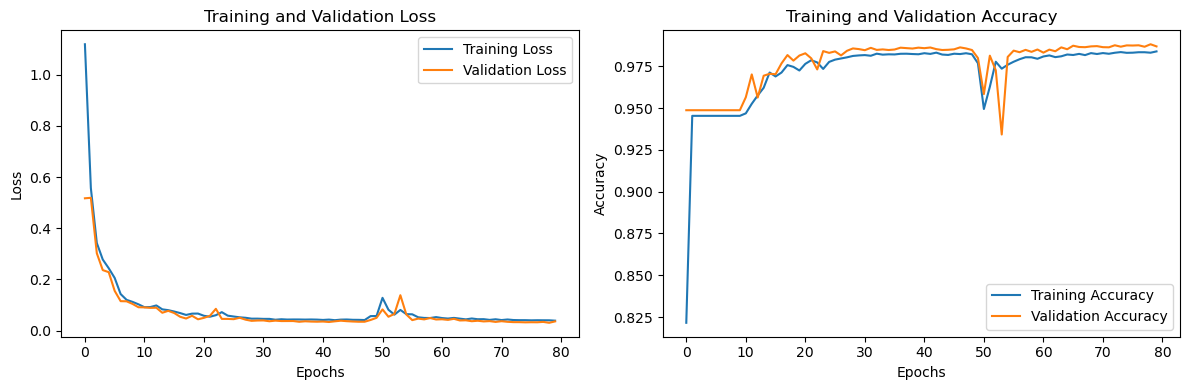

In [10]:
# Train the model and capture the history
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=80
)

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [11]:
model.save('epidermus_segmenter_mark3.h5')

# model.save('epidermus_segmenter_mark2')

1/1 [==============================] - 1s 722ms/step


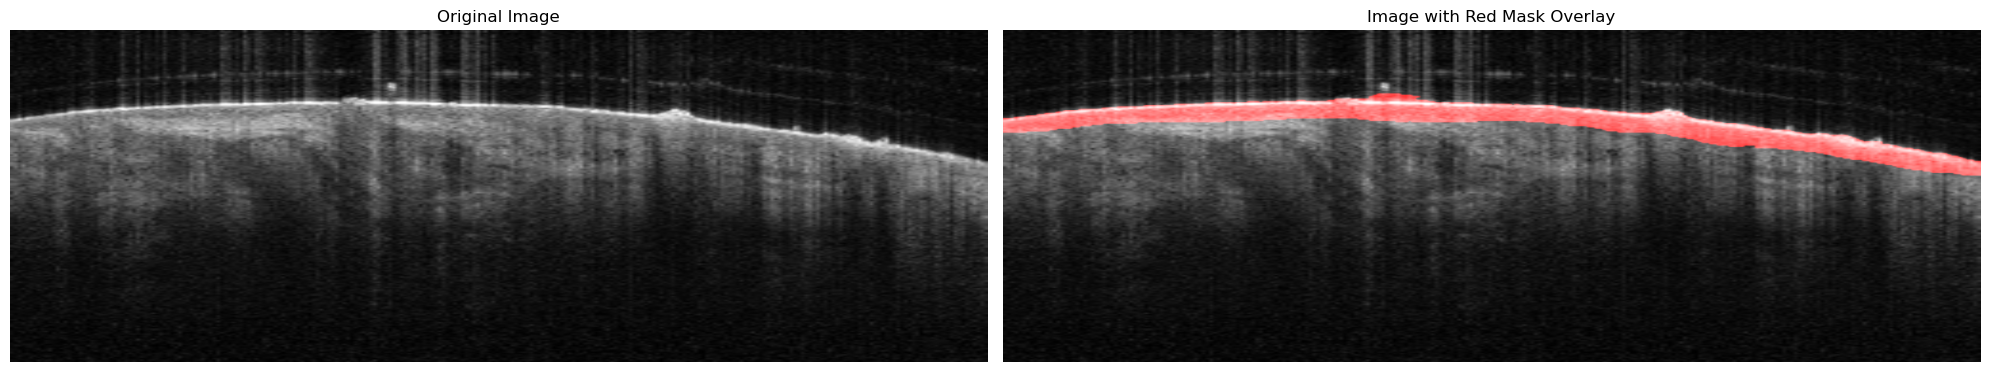

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def test_model_on_sample_image(model, image_path):
    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, (256, 256))
    img = tf.cast(img, tf.float32) / 255.0  # Normalize image to [0, 1]
    img = tf.expand_dims(img, axis=0)  # Add batch dimension

    # Predict the mask
    pred_mask = model.predict(img)
    pred_mask = tf.squeeze(pred_mask, axis=0)  # Remove batch dimension
    pred_mask = tf.round(pred_mask)  # Binarize the predicted mask
    
    # Resize the predicted mask to 460x1355
    resized_mask = tf.image.resize(pred_mask, (460, 1355))
    resized_mask = tf.squeeze(resized_mask, axis=-1)  # Remove the last dimension
    
    # Load and resize the original image to 460x1355 (keeping 3 channels for RGB display)
    original_img = tf.image.resize(tf.squeeze(img, axis=0), (460, 1355))  # Remove batch dimension but keep the channel
    original_img = tf.repeat(original_img, 3, axis=-1)  # Convert to 3 channels for RGB
    
    # Convert mask to red overlay
    red_mask = np.zeros((460, 1355, 3))  # Initialize a black image with 3 channels
    red_mask[:, :, 0] = resized_mask  # Assign the mask to the red channel
    
    # Overlay the red mask on the original image
    overlayed_img = np.clip(original_img + red_mask, 0, 1)  # Ensure the values are in [0, 1] range

    # Plot the original image and mask overlay
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(tf.squeeze(original_img), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_img)
    plt.title('Image with Red Mask Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    return resized_mask

# Test the model on a sample image
test_sample_image_path = r"E:\DTU\Bachelor_data\Segmentation\Data\image_39.png"  # Use the first image from the dataset
p_mask = test_model_on_sample_image(model, test_sample_image_path)


In [13]:



# Save in SavedModel format
model.save("mark_2_matlab", save_format="tf")


INFO:tensorflow:Assets written to: mark_2_matlab\assets


INFO:tensorflow:Assets written to: mark_2_matlab\assets


In [10]:
loaded_model = tf.keras.models.load_model("mark_2_matlab")
print("Model loaded successfully in TensorFlow.")

Model loaded successfully in TensorFlow.
